In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)} # String to Int
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # Int to String
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
def build_dataset(words, block_size):
    """
    Build a dataset of the words using the block size of characters as the
    samples and the next character as the label.
    """

    # context length of characters taken to predict the next 
    X, Y = [],[]

    for w in words:
        
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
BLOCK_SIZE = 3
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words)) 
Xtrain, Ytrain = build_dataset(words[:n1], BLOCK_SIZE)
Xdev, Ydev = build_dataset(words[n1:n2], BLOCK_SIZE)
Xtest, Ytest = build_dataset(words[n2:], BLOCK_SIZE)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
N_EMB = 10
N_HIDDEN = 200

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, N_EMB), generator=g)
w1 = torch.randn((N_EMB * BLOCK_SIZE, N_HIDDEN), generator=g) * (5/3)/((N_EMB*BLOCK_SIZE)**0.5)#0.2
# b1 = torch.randn((N_HIDDEN), generator=g) * 0.01
w2 = torch.randn((N_HIDDEN, 27), generator=g) * 0.01
b2 = torch.randn((27), generator=g) * 0

bngain = torch.ones((1, N_HIDDEN))
bnbias = torch.zeros((1, N_HIDDEN))
bnmean_running = torch.zeros((1, N_HIDDEN))
bnstd_running = torch.ones((1, N_HIDDEN))

parameters = [c, w1, w2, b2, bngain, bnbias]
nparameters = sum(p.nelement() for p in parameters)
print(f'{nparameters} parameters')


for p in parameters:
    p.requires_grad = True

12097 parameters


tensor(-0.0082) tensor(1.0012)
tensor(0.0012) tensor(1.0005)


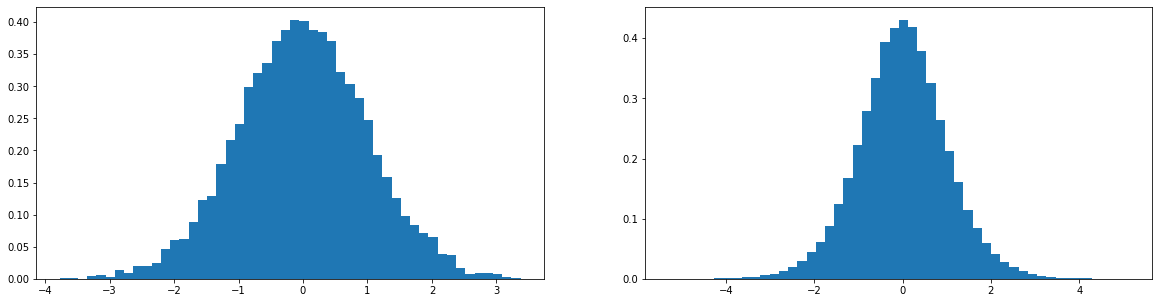

In [7]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [8]:
MAX_STEPS = 200_000
BATCH_SIZE = 32
EVAL_INTERVAL = 10_000

train_loss = []

for i in range(MAX_STEPS):
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass
    emb = c[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear
    hpreact = embcat @ w1 # no bias when doing batchnorm
    # Batchnorm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001* bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001* bnstdi

    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < MAX_STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr  * p.grad

    # track stats
    if i%(EVAL_INTERVAL) == 0:
        print(f"{i:7d}/{MAX_STEPS:7d}: {loss.item():.4f}")
    train_loss.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


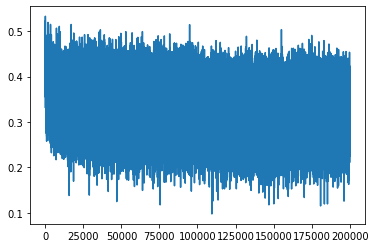

In [9]:
plt.plot(train_loss)

In [10]:
with torch.no_grad():
    emb = c[Xtrain]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1# + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [11]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val':  (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    emb = c[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 # + b1
    hpreact = bngain * (hpreact - bnmean_running )/ bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yb)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.9877216815948486
val 1.9877216815948486


In [12]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * BLOCK_SIZE
    while True:
        emb = c[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ w1 # + b1
        hpreact = bngain * (hpreact - bnmean_running )/ bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carlah.
amorie.
khi.
mri.
reity.
salaysie.
mahnen.
delynn.
jareei.
ner.
kiah.
maiivia.
leigh.
ham.
joce.
quint.
salin.
alianni.
wate.
madiaryn.


# Deeper network

In [60]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

        def __call__(self, x):

            if self.training:
                xmean = x.mean(0, keepdims=True)
                xvar = x.var(0, keepdims=True)
            else:
                xmean = self.running_mean
                xvar = self.running_var
            xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
            self.out = self.gamma * xhat + self.beta

            if self.training:
                with torch.no_grad():
                    self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                    self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            return self.out
        
        def parameters(self):
            return [self.gamma, self.beta]
        
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [61]:
N_EMB = 10
N_HIDDEN = 100
VOCAB_SIZE = 27
MAX_STEPS = 200_000
BATCH_SIZE = 32
lossi = []
ud = []

g = torch.Generator().manual_seed(2147483647)

c = torch.randn((VOCAB_SIZE, N_EMB), generator=g)
layers = [
    Linear(N_EMB* BLOCK_SIZE, N_HIDDEN), Tanh(), 
    Linear(N_HIDDEN, N_HIDDEN), Tanh(), 
    Linear(N_HIDDEN, N_HIDDEN), Tanh(), 
    Linear(N_HIDDEN, N_HIDDEN), Tanh(), 
    Linear(N_HIDDEN, N_HIDDEN), Tanh(),
    Linear(N_HIDDEN, VOCAB_SIZE),
]

with torch.no_grad():
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *+ 5/3

parameters = [c] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [62]:
for i in range(MAX_STEPS):

    ix = torch.randint(0, Xtrain.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    emb = c[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d} / {MAX_STEPS:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    break
    # if i >= 10000:
    #     break

      0 /  200000: 3.2988


layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

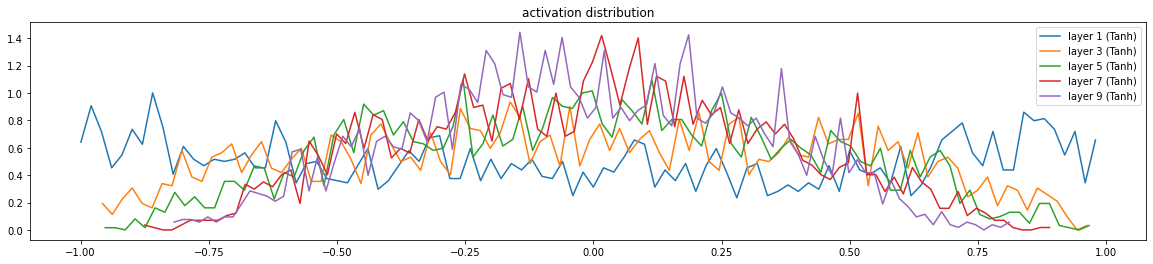

In [63]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.00, std 0.00,
layer 3 (      Tanh): mean -0.00, std 0.00,
layer 5 (      Tanh): mean +0.00, std 0.00,
layer 7 (      Tanh): mean +0.00, std 0.00,
layer 9 (      Tanh): mean -0.00, std 0.00,


Text(0.5, 1.0, 'gradient distribution')

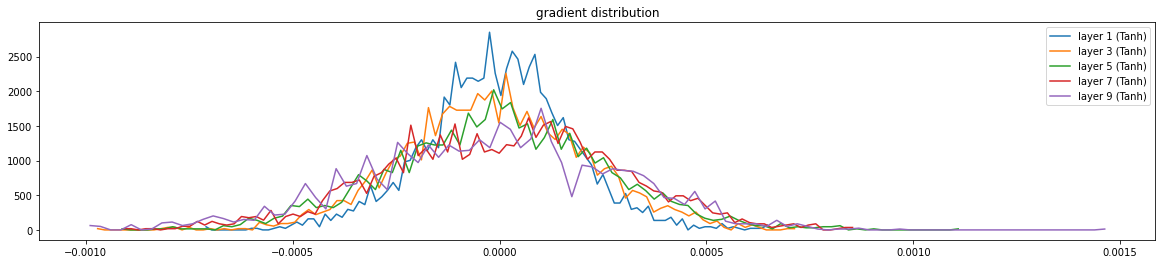

In [64]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f,' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('gradient distribution')